## Plot CO2 Fluxes for LDEO-HPD (time series)
#### Also plots vs. Volcano time series

In [4]:
# see /home/vbennington/LDEO_HPD/hpd_hist_flux.ipynb for all version of flux timeseries plots

In [2]:
import datetime
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'jpeg'
%config InlineBackend.print_figure_kwargs = {'dpi':600}

In [6]:
recon_output_dir = f'/data/artemis/workspace/vbennington/LDEO_HPD/models/XGB/GCB_2021/reconstructions'

#models = ['cesm_fgco2_1x1_A','csiro_fgco2_1x1_A','fesom_fgco2_1x1_A','mpi_fgco2_1x1_A','cnrm_fgco2_1x1_A','ipsl_fgco2_1x1_A','planktom_fgco2_1x1_A',
#               'noresm_fgco2_1x1_A','princeton_fgco2_1x1_A',]
#modname = ['cesm','csiro','fesom','mpi','cnrm','ipsl','planktom','noresm','princeton',]

models = ['cesm_fgco2_1x1_A','fesom2_fgco2_1x1_A','mpi_fgco2_1x1_A','cnrm_fgco2_1x1_A','ipsl_fgco2_1x1_A','planktom_fgco2_1x1_A',
               'noresm_fgco2_1x1_A','princeton_fgco2_1x1_A',]
modname = ['cesm','fesom2','mpi','cnrm','ipsl','planktom','noresm','princeton']

## Get GCB2021 Model Fluxes

In [3]:
fk = xr.open_dataset('/data/artemis/observations/SOCOM/extra_files/FluxKit_calculation_1982-2019_v20201120.nc')
# Only look at open ocean:
mask = xr.open_dataset('/data/artemis/observations/SOCOM/extra_files/RECCAP2_region_masks_all.nc') 
#replace longitude from 0-360 to -180 to 180
mask['lon'] = list(map(lambda x: x-360 if x>180 else x, mask['lon'].values))
# Sort by longitude
mask = mask.sortby('lon')

In [7]:
dm = xr.open_dataset('/data/artemis/simulations/GCB/2021models/gcb_load_A_2021_models.nc',decode_times=False)
dm = dm.rename({'X':'lon','Y':'lat','T':'time'})
dm['lon'] = list(map(lambda x: x-360 if x>180 else x, dm['lon'].values))
dm = dm.sortby('lon')
dm['time']=pd.date_range(start=f'1958-01T00:00:00.000000000',end=f'2020-12T00:00:00.000000000',freq='MS') + np.timedelta64(14, 'D')

for mod in models: # loop on different model fluxes
    # grab gridded flux and multiply by area:
    gflux = (dm[f'{mod}'].where(mask['open_ocean']>=1)*(fk.area)).sum(['lat','lon']).groupby("time.year").mean("time")
    dm[f"{mod}_annual_flux"] = gflux * (365*24*60*60) * 12.01 / (10**15)
    del gflux

## Get CarboScope Fluxes (Rodenbeck 2021)

In [41]:
cdir = "/data/artemis/simulations/CarboScope"
carb = xr.load_dataset(f"{cdir}/CarboScope_CO2flux_timeseries_1957-2020.nc")
carboscope = carb.CO2_flux
print(carb)

<xarray.Dataset>
Dimensions:   (year: 64)
Coordinates:
  * year      (year) int64 1957 1958 1959 1960 1961 ... 2016 2017 2018 2019 2020
Data variables:
    CO2_flux  (year) float32 0.04246 -0.2057 -0.2368 ... -2.554 -2.508 -2.588
Attributes:
    title:         Jena CarboScope results
    history:       Inversion code by Christian Roedenbeck
    institution:   MPI Biogeochemistry Jena
    references:    http://www.BGC-Jena.mpg.de/CarboScope/
    date_created:  2022-01-12 13:36:17.906676


## Get Latest LDEO-HPD Results

In [9]:
ldeo = xr.load_dataset(f'{recon_output_dir}/CO2flux_cc2000-2020_1x1_recon_1959-2020.nc')
hpd = ldeo.CO2 # HPD
hpdclim = ldeo.CO2cc  # Climatological Correction

# Data Products (1990-2019)

In [10]:
seaflux = xr.open_dataset("/data/artemis/observations/SOCOM/extra_files/SeaFlux_v2021.04_fgco2_all_winds_products.nc")
print(seaflux.wind)
# Don't use NCEP winds
print(seaflux.time)

<xarray.DataArray 'wind' (wind: 5)>
array(['CCMP2', 'ERA5', 'JRA55', 'NCEP1', 'NCEP2'], dtype=object)
Coordinates:
  * wind     (wind) object 'CCMP2' 'ERA5' 'JRA55' 'NCEP1' 'NCEP2'
<xarray.DataArray 'time' (time: 360)>
array(['1990-01-15T00:00:00.000000000', '1990-02-15T00:00:00.000000000',
       '1990-03-15T00:00:00.000000000', ..., '2019-10-15T00:00:00.000000000',
       '2019-11-15T00:00:00.000000000', '2019-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1990-01-15 1990-02-15 ... 2019-12-15


In [11]:
pflux = {}
for prod in seaflux.product.values:
    print(prod)
    pflux[f"{prod}"] = (seaflux.fgco2.sel(product=prod).sel(wind=['CCMP2', 'ERA5', 'JRA55']).mean("wind").where(mask['open_ocean']>=1)*(fk.area)).sum(['lat','lon']).groupby("time.year").mean("time")* 12.01 / (10**15)

JENA_MLS
MPI_SOMFFN
CMEMS_FFNN
CSIR_ML6
JMA_MLR
NIES_FNN


In [62]:
prod2021 = xr.open_dataset("/data/artemis/simulations/GCB/2021models/gcb_load_2021_dataprod.nc")
prod2021 = prod2021.rename({"T":"time","Y":"lat","X":"lon"})
prod2021['time']=dm['time']
prod2021['lon'] = list(map(lambda x: x-360 if x>180 else x, prod2021['lon'].values))
prod2021 = prod2021.sortby('lon')
print(prod2021.time)

<xarray.DataArray 'time' (time: 756)>
array(['1958-01-15T00:00:00.000000000', '1958-02-15T00:00:00.000000000',
       '1958-03-15T00:00:00.000000000', ..., '2020-10-15T00:00:00.000000000',
       '2020-11-15T00:00:00.000000000', '2020-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1958-01-15 1958-02-15 ... 2020-12-15


In [51]:
# 2021 netcdf has product fluxes (mol C / m2 / sec):
newprod = {}
for prod in ['roeden','land','cmems','gracer','watson','iida','zeng','csir']:
    print(prod)
    newprod[f"{prod}"] = (prod2021[f"{prod}_fgco2_1x1_A"].where(mask['open_ocean']>=1)*(fk.area)).sum(['lat','lon']).groupby("time.year").mean("time")* 12.01 *365*24*60*60 / (10**15)

roeden
land
cmems
gracer
watson
iida
zeng
csir


In [52]:
for prod in ['roeden','land','cmems','gracer','watson','iida','zeng','csir']:
    print(prod)
    newprod[f"{prod}"] = np.where(newprod[f"{prod}"]>0,newprod[f"{prod}"],np.nan)

roeden
land
cmems
gracer
watson
iida
zeng
csir


In [13]:
# Get the pCO2-Residual Flux as well:
ds = xr.load_dataset("/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC/models/reconstructions/xg/reconstructed_fluxes_1982-2019.nc")
residual = ds.annual_flux.sel(product='pCO$_2$-Residual').sel(wind=['CCMP2','ERA5','JRA55']).mean("wind").sel(year=slice("1990","2019"))

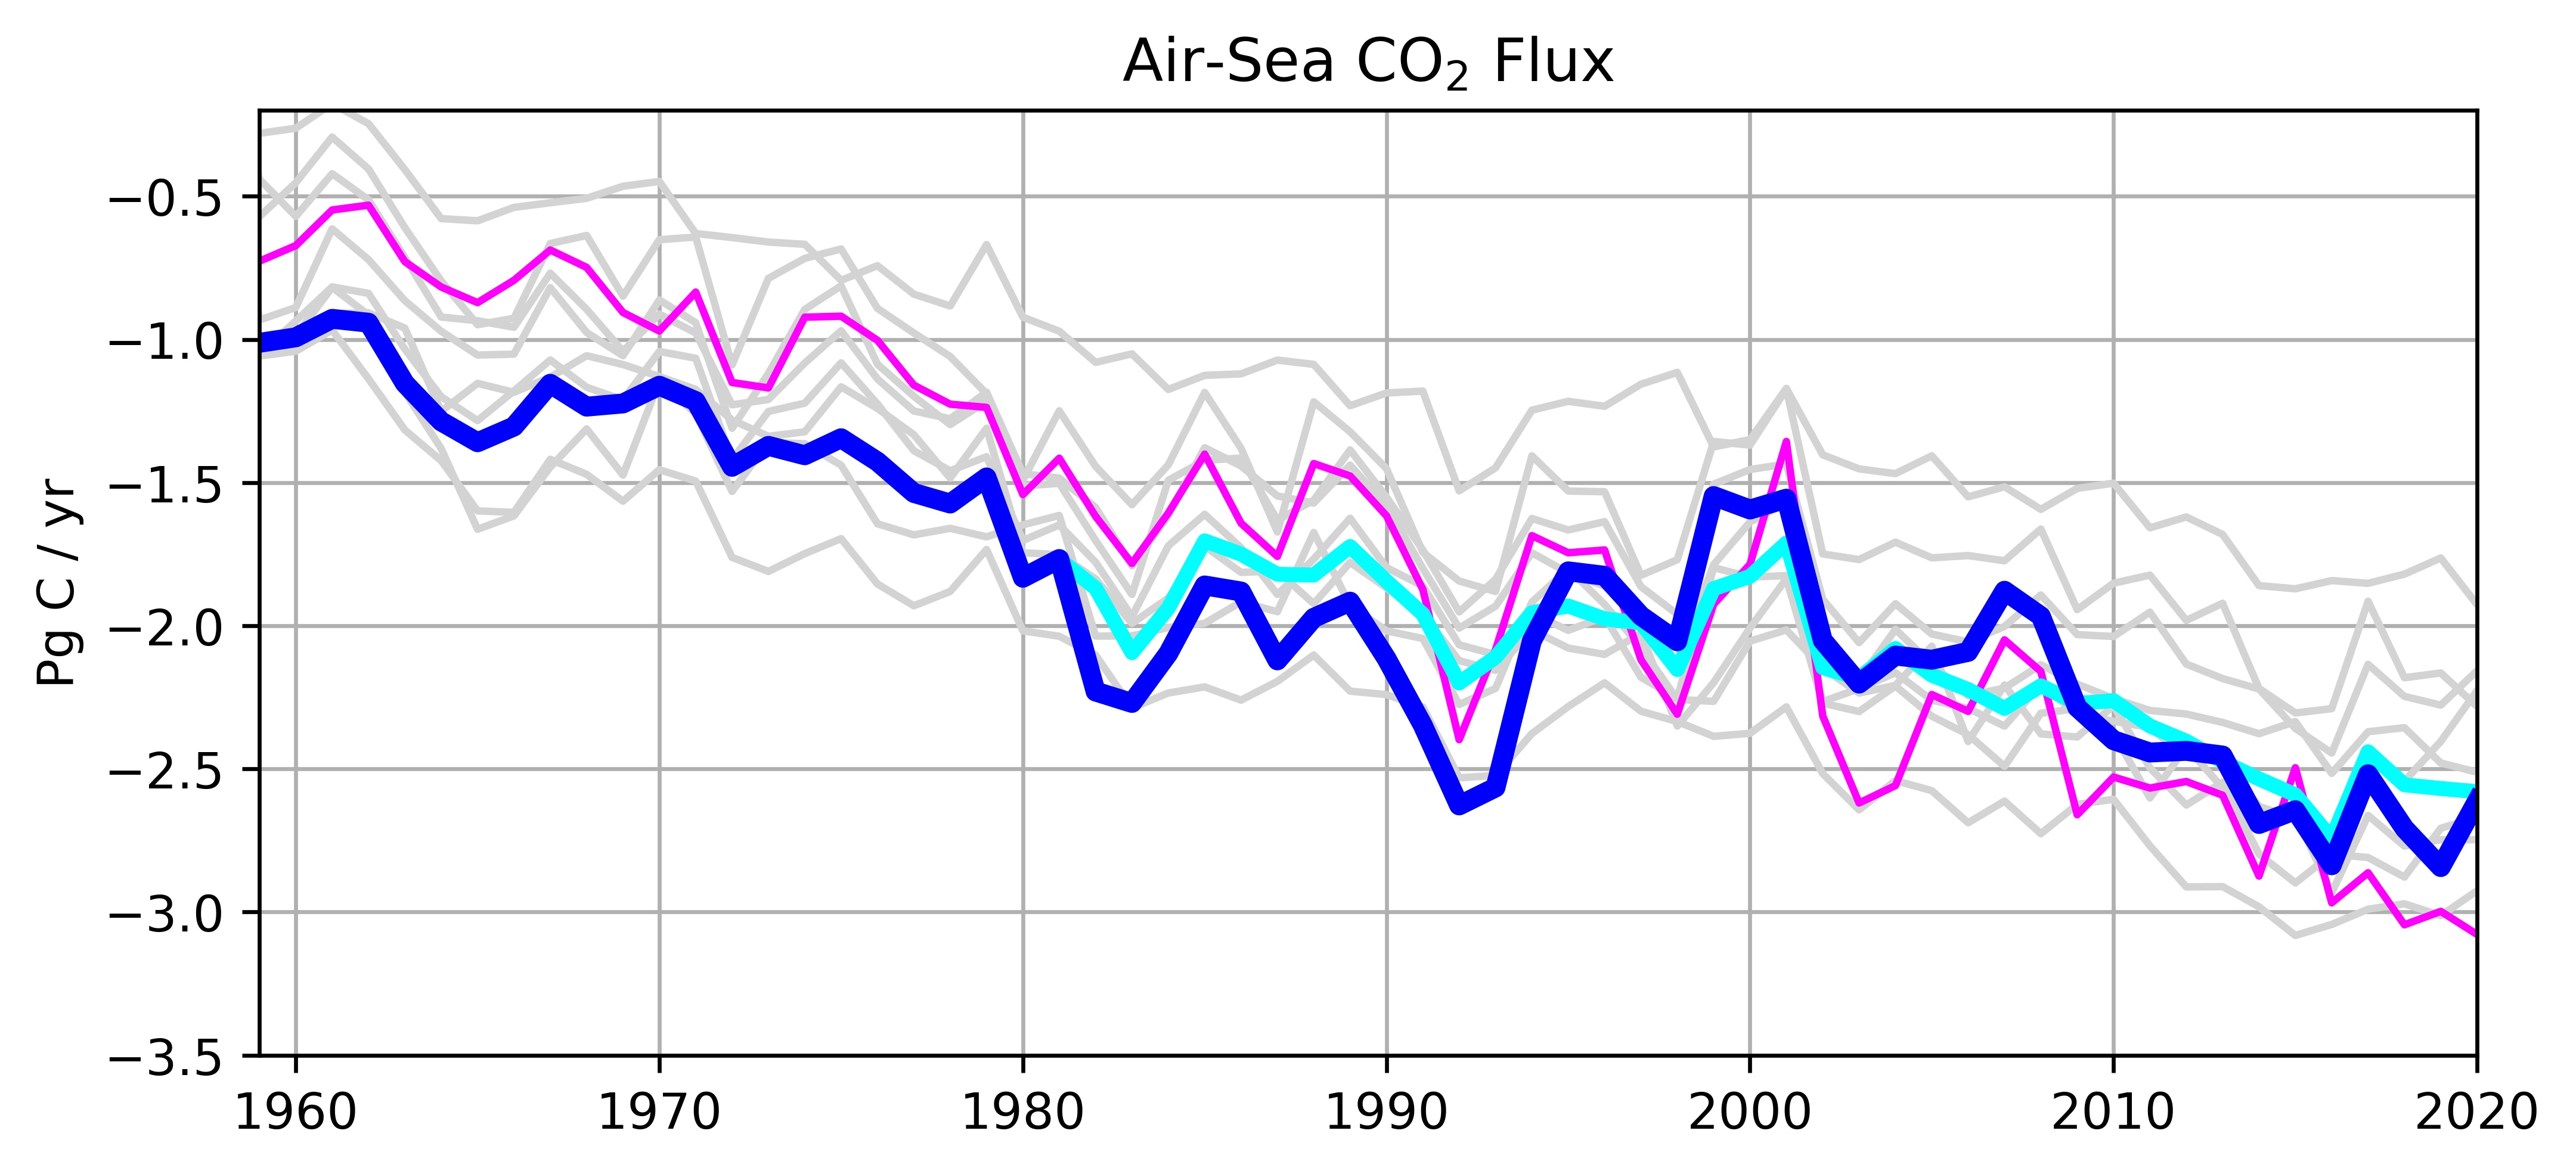

In [15]:
## Plot models and CarboScope Together:
fig = plt.figure(figsize=(8,3.5))
for mod in models:
    var = dm[f"{mod}_annual_flux"]
    plt.plot(var.year,-1*var.values,color='lightgray') #label=f"{modname[m]}"
    del var
    
# Add CarboScope:
plt.plot(carboscope.year,carboscope-0.49,color='magenta')#label=prod)
    
# Add HPD (Clim prior to 1982, HPD full from 1982 onward):
plt.plot(hpdclim.year.sel(year=slice(1959,2020)),hpdclim.sel(year=slice(1959,2020))-0.49,color='cyan',linewidth=3,label='LDEO HPD CC')
plt.plot(hpd.year.sel(year=slice(1959,2020)),hpd.sel(year=slice(1959,2020))-0.49,color='blue',linewidth=4,label='LDEO HPD')


plt.xlim(1959,2020)
plt.grid(True)
plt.ylim(-3.5,-0.2)
plt.ylabel("Pg C / yr")
#plt.legend()
plt.title("Air-Sea CO$_2$ Flux")

plt.savefig(f"{recon_output_dir}/CO2flux_HPD_models_CarboScope_1959-2020.eps",format='eps',dpi=600)

## With Data Products Now

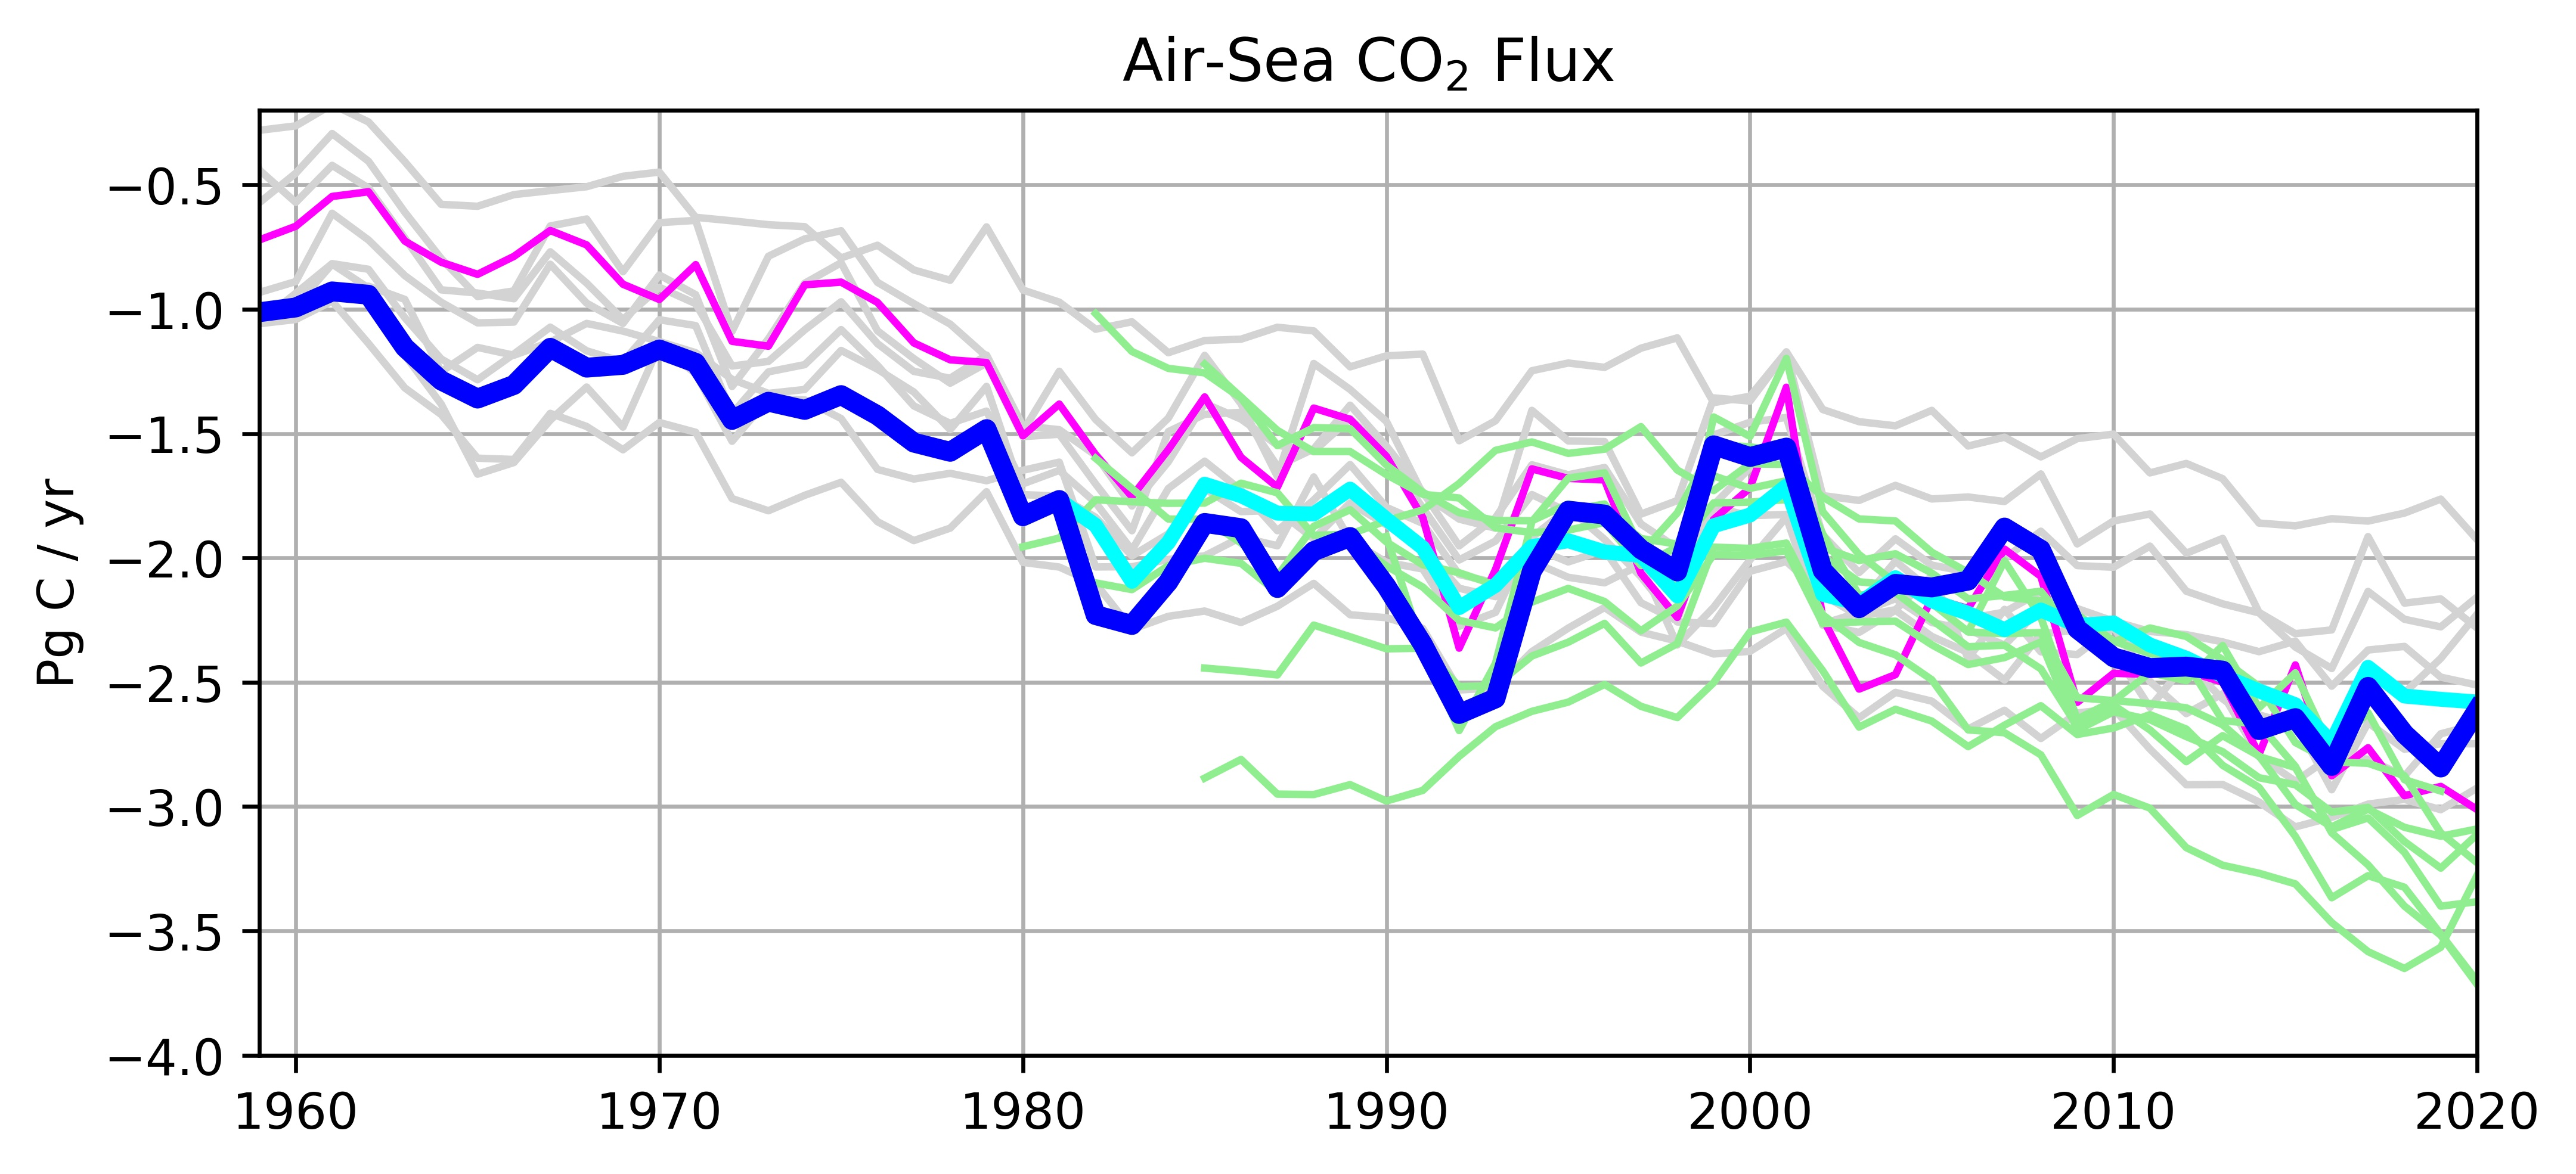

In [64]:
## Plot models and CarboScope Together:
fig = plt.figure(figsize=(8,3.5))
for mod in models:
    var = dm[f"{mod}_annual_flux"]
    plt.plot(var.year,-1*var.values,color='lightgray') #label=f"{modname[m]}"
    del var
    
# Add CarboScope:
for prod in ['roeden']:
    plt.plot(range(1959,2022),-1*newprod[f"{prod}"]-0.49,color='magenta')

# Add Other Products
for prod in ['land','cmems','gracer','watson','iida','zeng','csir']:
    plt.plot(range(1958,2021),-1*newprod[f"{prod}"]-0.49,color='lightgreen')
    
plt.plot(range(1990,2020),residual/10**15-0.49,color='lightgreen')

# Add HPD (Clim prior to 1982, HPD full from 1982 onward):
plt.plot(hpdclim.year.sel(year=slice(1959,2020)),hpdclim.sel(year=slice(1959,2020))-0.49,color='cyan',linewidth=3,label='LDEO HPD CC')
plt.plot(hpd.year.sel(year=slice(1959,2020)),hpd.sel(year=slice(1959,2020))-0.49,color='blue',linewidth=4,label='LDEO HPD')


plt.xlim(1959,2020)
plt.grid(True)
plt.ylim(-4,-0.2)
plt.ylabel("Pg C / yr")
#plt.legend()
plt.title("Air-Sea CO$_2$ Flux")

plt.savefig(f"{recon_output_dir}/CO2flux_HPD_models_CarboScope_allProducts_1959-2020.eps",format='eps',dpi=600)

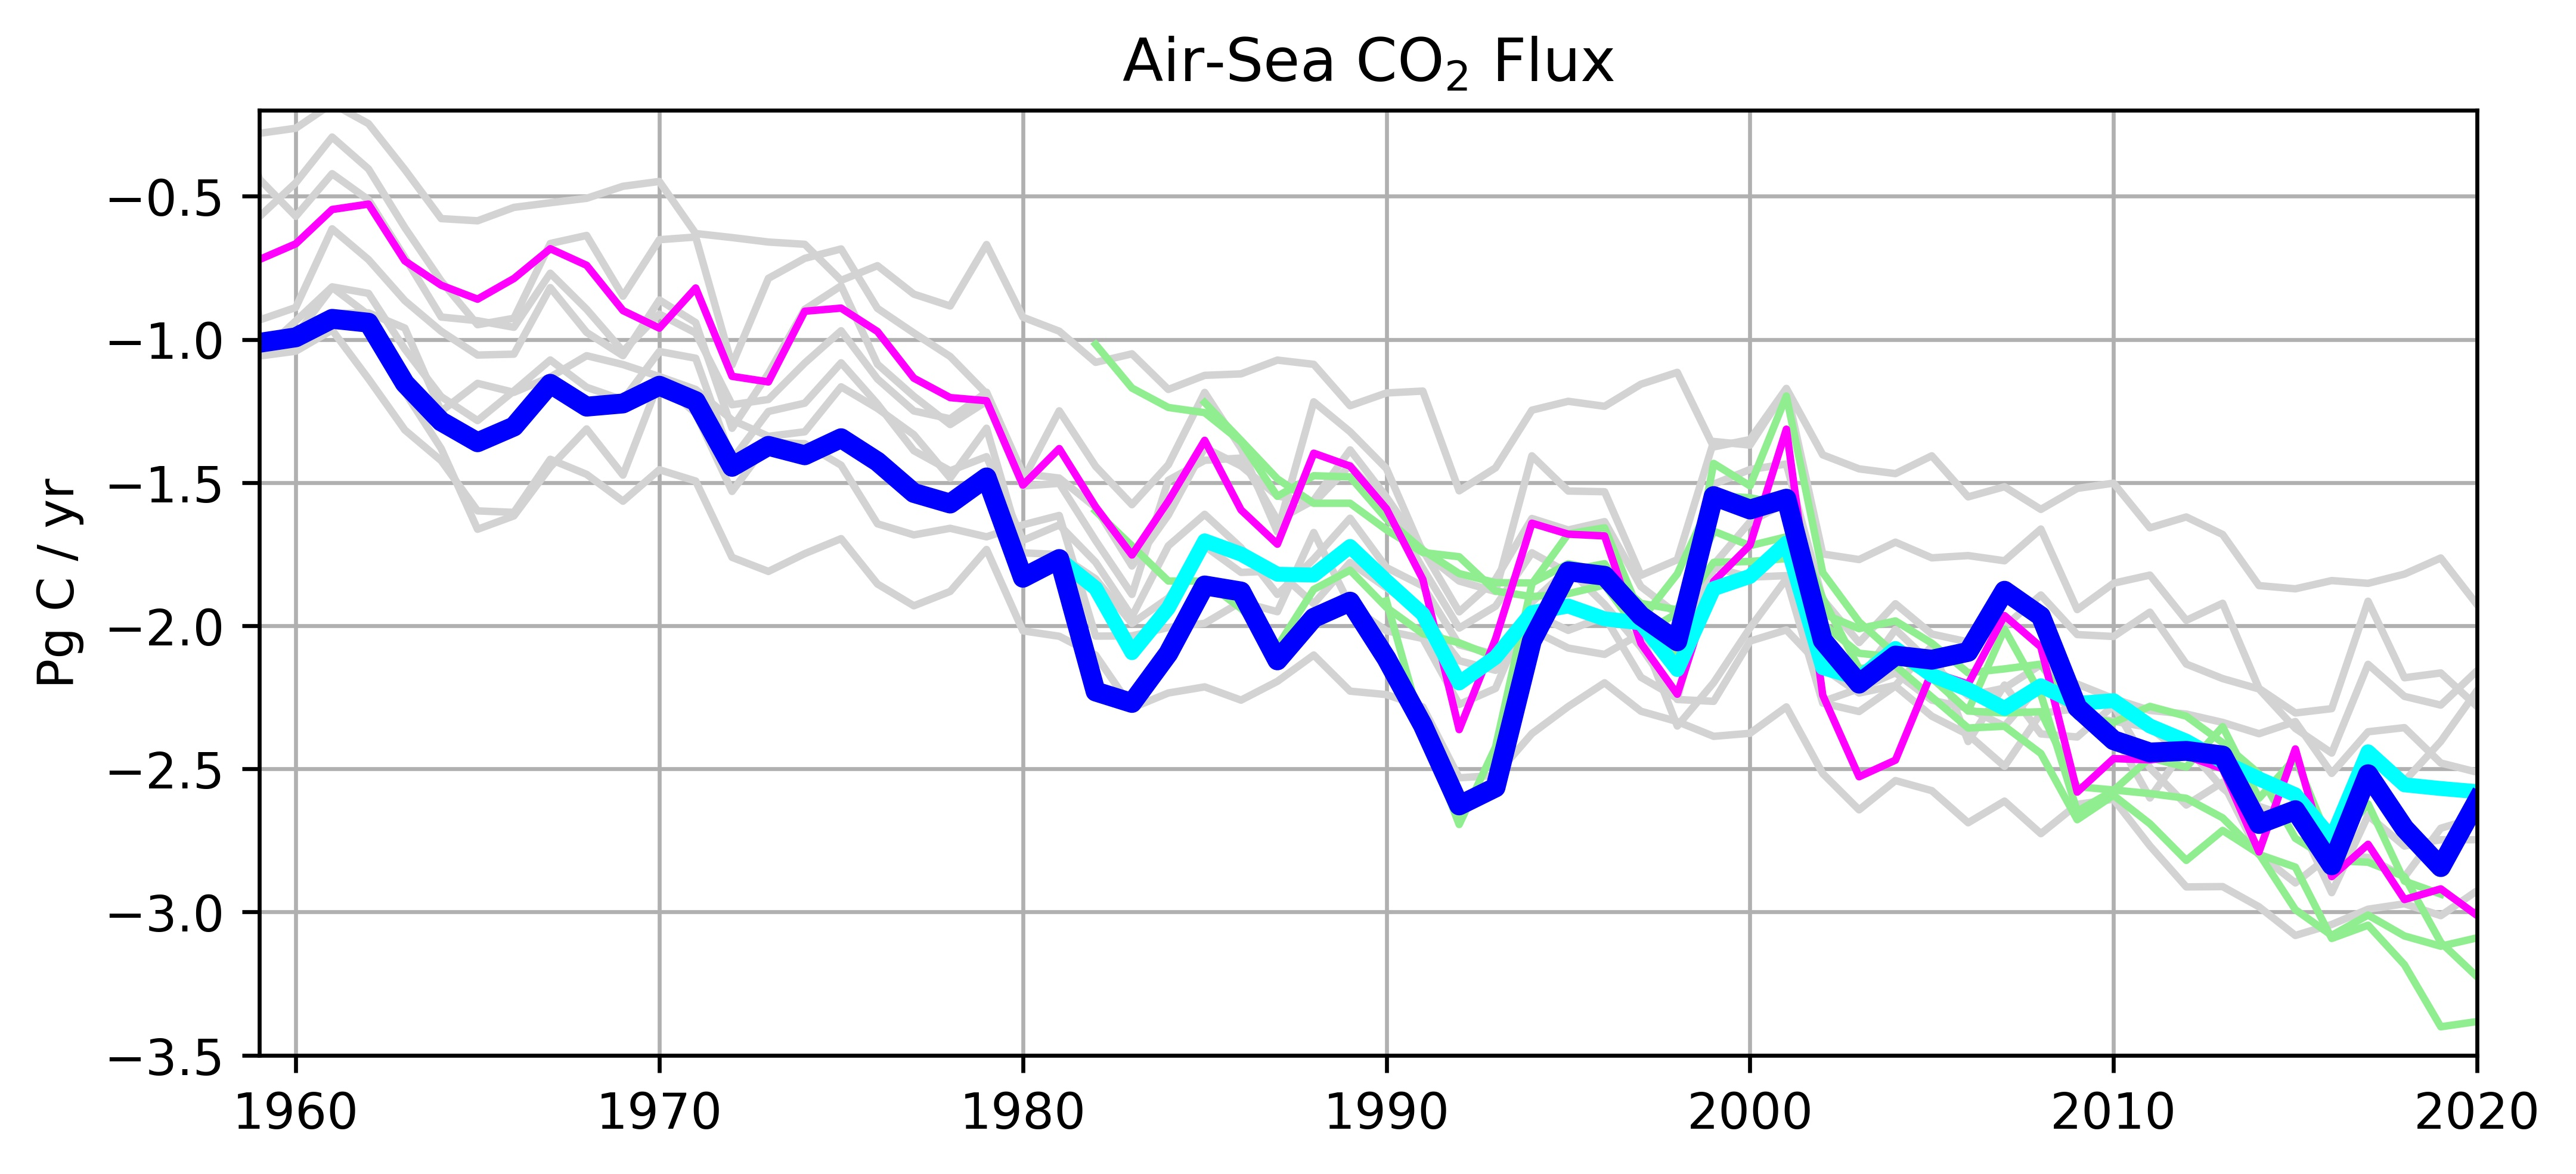

In [68]:
## Plot models and CarboScope Together:
fig = plt.figure(figsize=(8,3.5))
for mod in models:
    var = dm[f"{mod}_annual_flux"]
    plt.plot(var.year,-1*var.values,color='lightgray') #label=f"{modname[m]}"
    del var
    
# Add Other Products
for prod in ['land','cmems','csir']:
    plt.plot(range(1958,2021),-1*newprod[f"{prod}"]-0.49,color='lightgreen')
    
plt.plot(range(1990,2020),residual/10**15-0.49,color='lightgreen')

# Add CarboScope:
for prod in ['roeden']:
    plt.plot(range(1959,2022),-1*newprod[f"{prod}"]-0.49,color='magenta')
#plt.plot(carboscope.year,carboscope-0.49,color='magenta')#label=prod)



# Add HPD (Clim prior to 1982, HPD full from 1982 onward):
plt.plot(hpdclim.year.sel(year=slice(1959,2020)),hpdclim.sel(year=slice(1959,2020))-0.49,color='cyan',linewidth=3,label='LDEO HPD CC')
plt.plot(hpd.year.sel(year=slice(1959,2020)),hpd.sel(year=slice(1959,2020))-0.49,color='blue',linewidth=4,label='LDEO HPD')


plt.xlim(1959,2020)
plt.grid(True)
plt.ylim(-3.5,-0.2)
plt.ylabel("Pg C / yr")
#plt.legend()
plt.title("Air-Sea CO$_2$ Flux")

plt.savefig(f"{recon_output_dir}/CO2flux_HPD_models_CarboScope_Products_1959-2020.eps",format='eps',dpi=600)

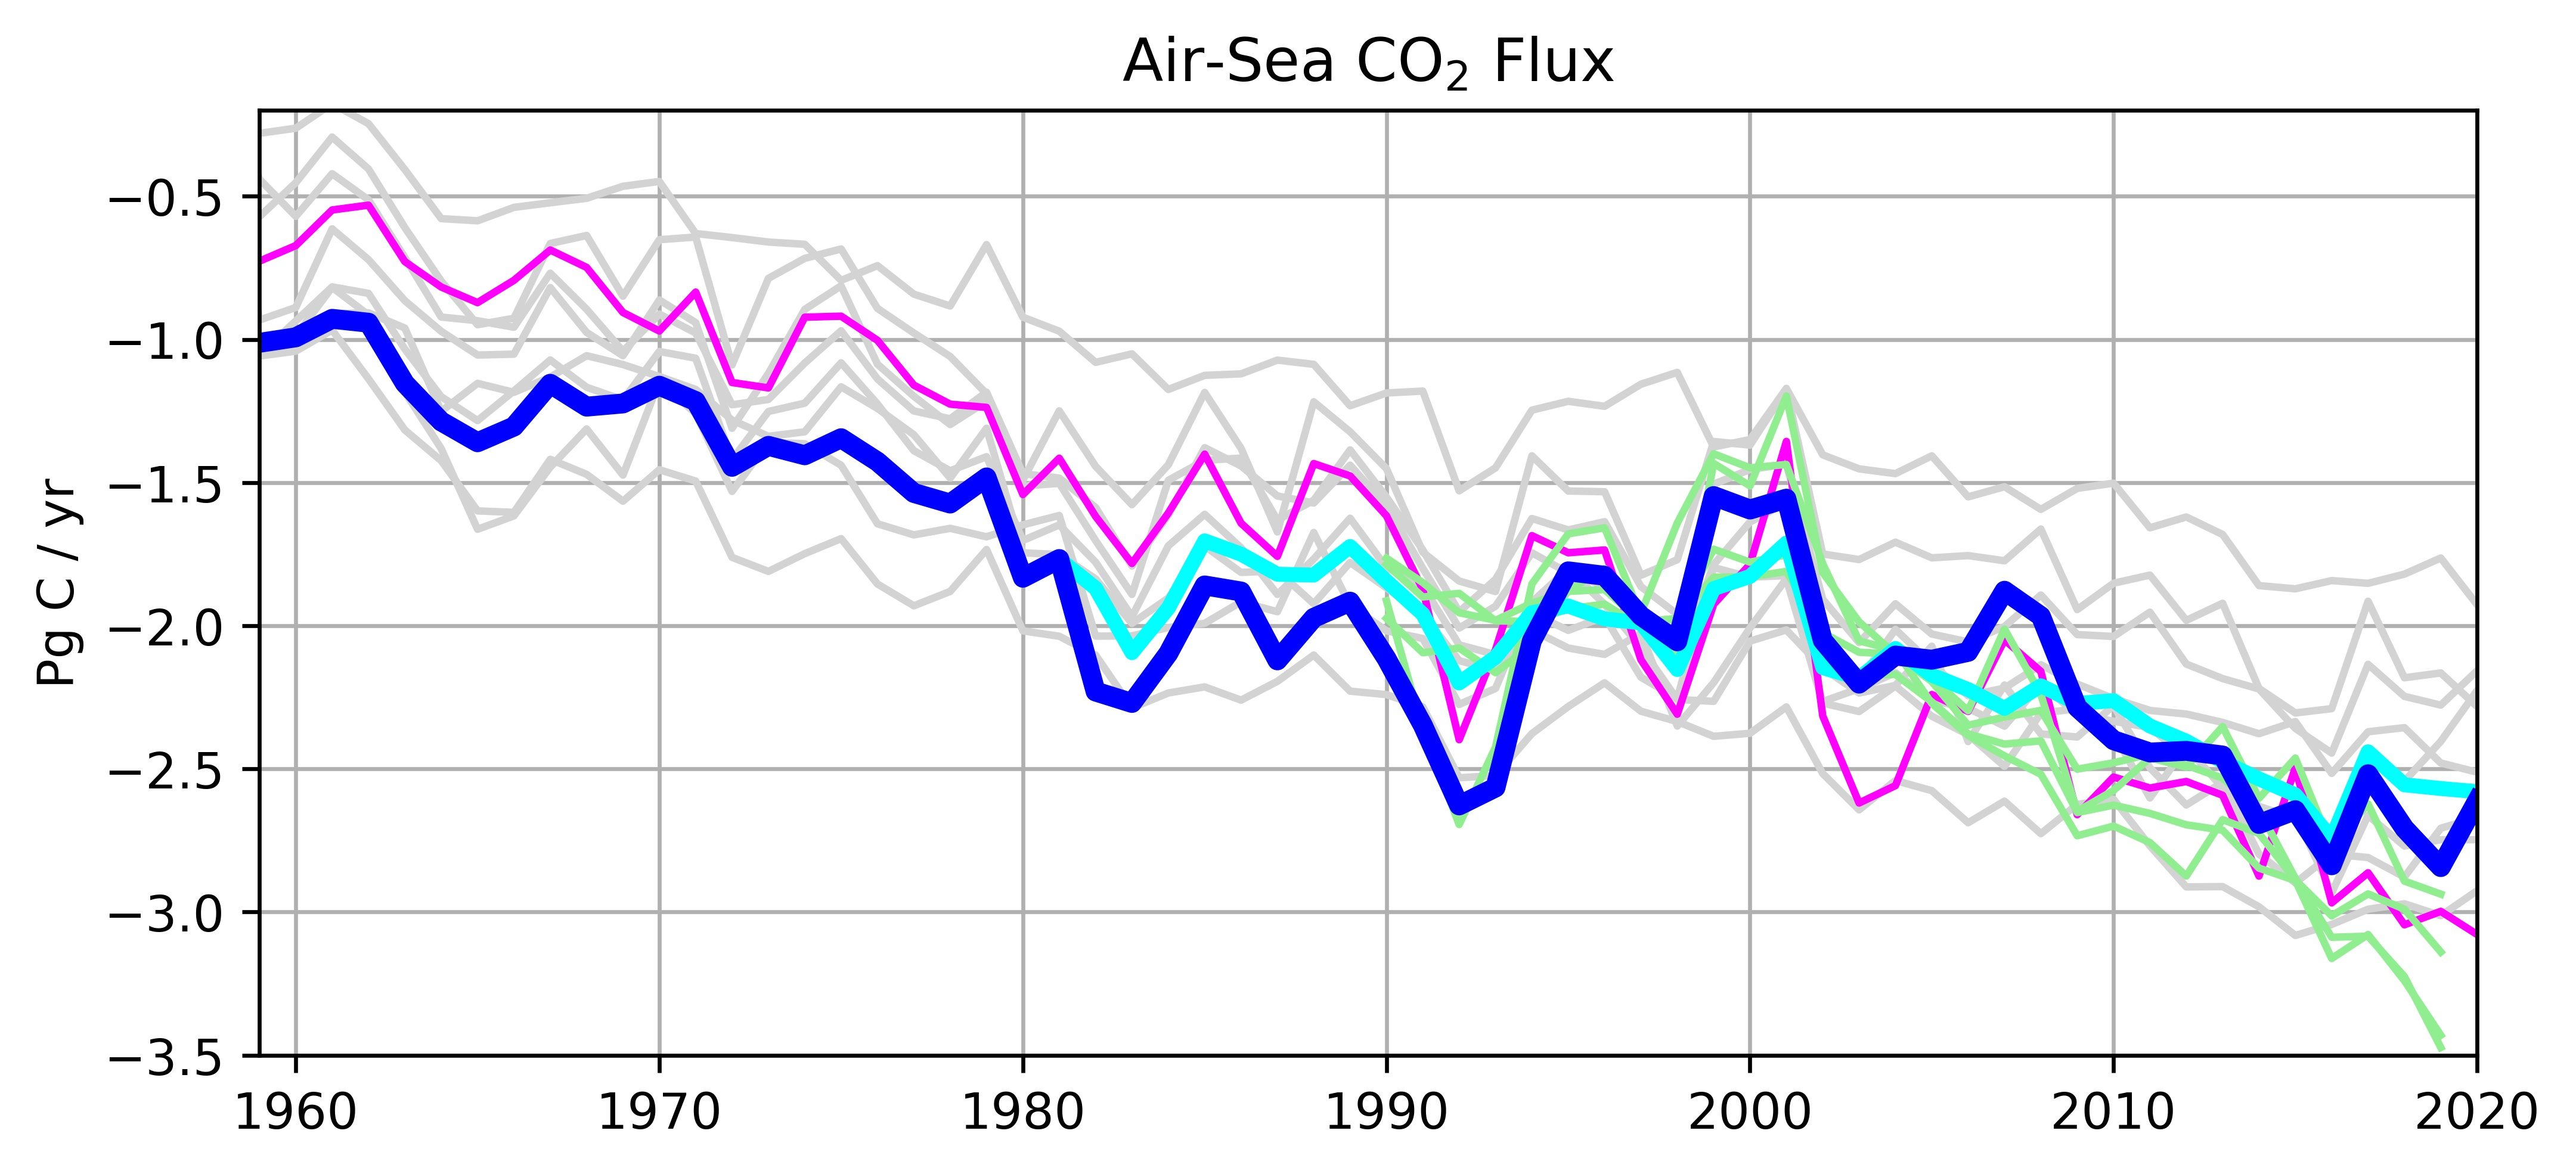

In [67]:
## Plot models and CarboScope Together:
fig = plt.figure(figsize=(8,3.5))
for mod in models:
    var = dm[f"{mod}_annual_flux"]
    plt.plot(var.year,-1*var.values,color='lightgray') #label=f"{modname[m]}"
    del var
    
# Add CarboScope:
plt.plot(carboscope.year,carboscope-0.49,color='magenta')#label=prod)

# Add Other Products
for prod in ["MPI_SOMFFN","CMEMS_FFNN","CSIR_ML6"]:
    plt.plot(range(1990,2020),pflux[f"{prod}"]-0.49,color='lightgreen')
    
plt.plot(range(1990,2020),residual/10**15-0.49,color='lightgreen')

# Add HPD (Clim prior to 1982, HPD full from 1982 onward):
plt.plot(hpdclim.year.sel(year=slice(1959,2020)),hpdclim.sel(year=slice(1959,2020))-0.49,color='cyan',linewidth=3,label='LDEO HPD CC')
plt.plot(hpd.year.sel(year=slice(1959,2020)),hpd.sel(year=slice(1959,2020))-0.49,color='blue',linewidth=4,label='LDEO HPD')


plt.xlim(1959,2020)
plt.grid(True)
plt.ylim(-3.5,-0.2)
plt.ylabel("Pg C / yr")
#plt.legend()
plt.title("Air-Sea CO$_2$ Flux")

plt.savefig(f"{recon_output_dir}/CO2flux_HPD_models_CarboScope_oldProducts_1959-2020.eps",format='eps',dpi=600)

## CarboScope JENA-MLS Correlations

In [18]:
from scipy import signal
from scipy import stats

In [19]:
pearson_coef, p_value = stats.pearsonr(hpd.sel(year=slice(1959,2020)).values, carboscope.sel(year=slice(1959,2020)).values)
print(pearson_coef)
print(p_value)

0.9282972754169994
1.8345953193155418e-27


In [20]:
pearson_coef, p_value = stats.pearsonr(signal.detrend(hpd.sel(year=slice(1959,2020)).values), signal.detrend(carboscope.sel(year=slice(1959,2020)).values))
print(pearson_coef)
print(p_value)

0.6601836605047705
5.3058109588888405e-09


In [21]:
pearson_coef, p_value = stats.pearsonr(signal.detrend(hpdclim.sel(year=slice(1959,2020)).values), signal.detrend(carboscope.sel(year=slice(1959,2020)).values))
print(pearson_coef)
print(p_value)

0.6388022957596685
2.3130886220872603e-08


## Volcano Comparisons

In [22]:
import scipy.io as spio

In [24]:
mat = spio.loadmat('/home/vbennington/simple_box_dic_varytemp.mat', squeeze_me=True)
volcanos = mat['fluxannual']

novolc_mat = spio.loadmat('/home/vbennington/simple_box_dic.mat', squeeze_me=True)
no_volcanos = novolc_mat['fluxannual']

fuego_mat = spio.loadmat('/home/vbennington/simple_box_dic_varytemp_Fernandina_Fuego.mat', squeeze_me=True)
fuego = fuego_mat['fluxannual']

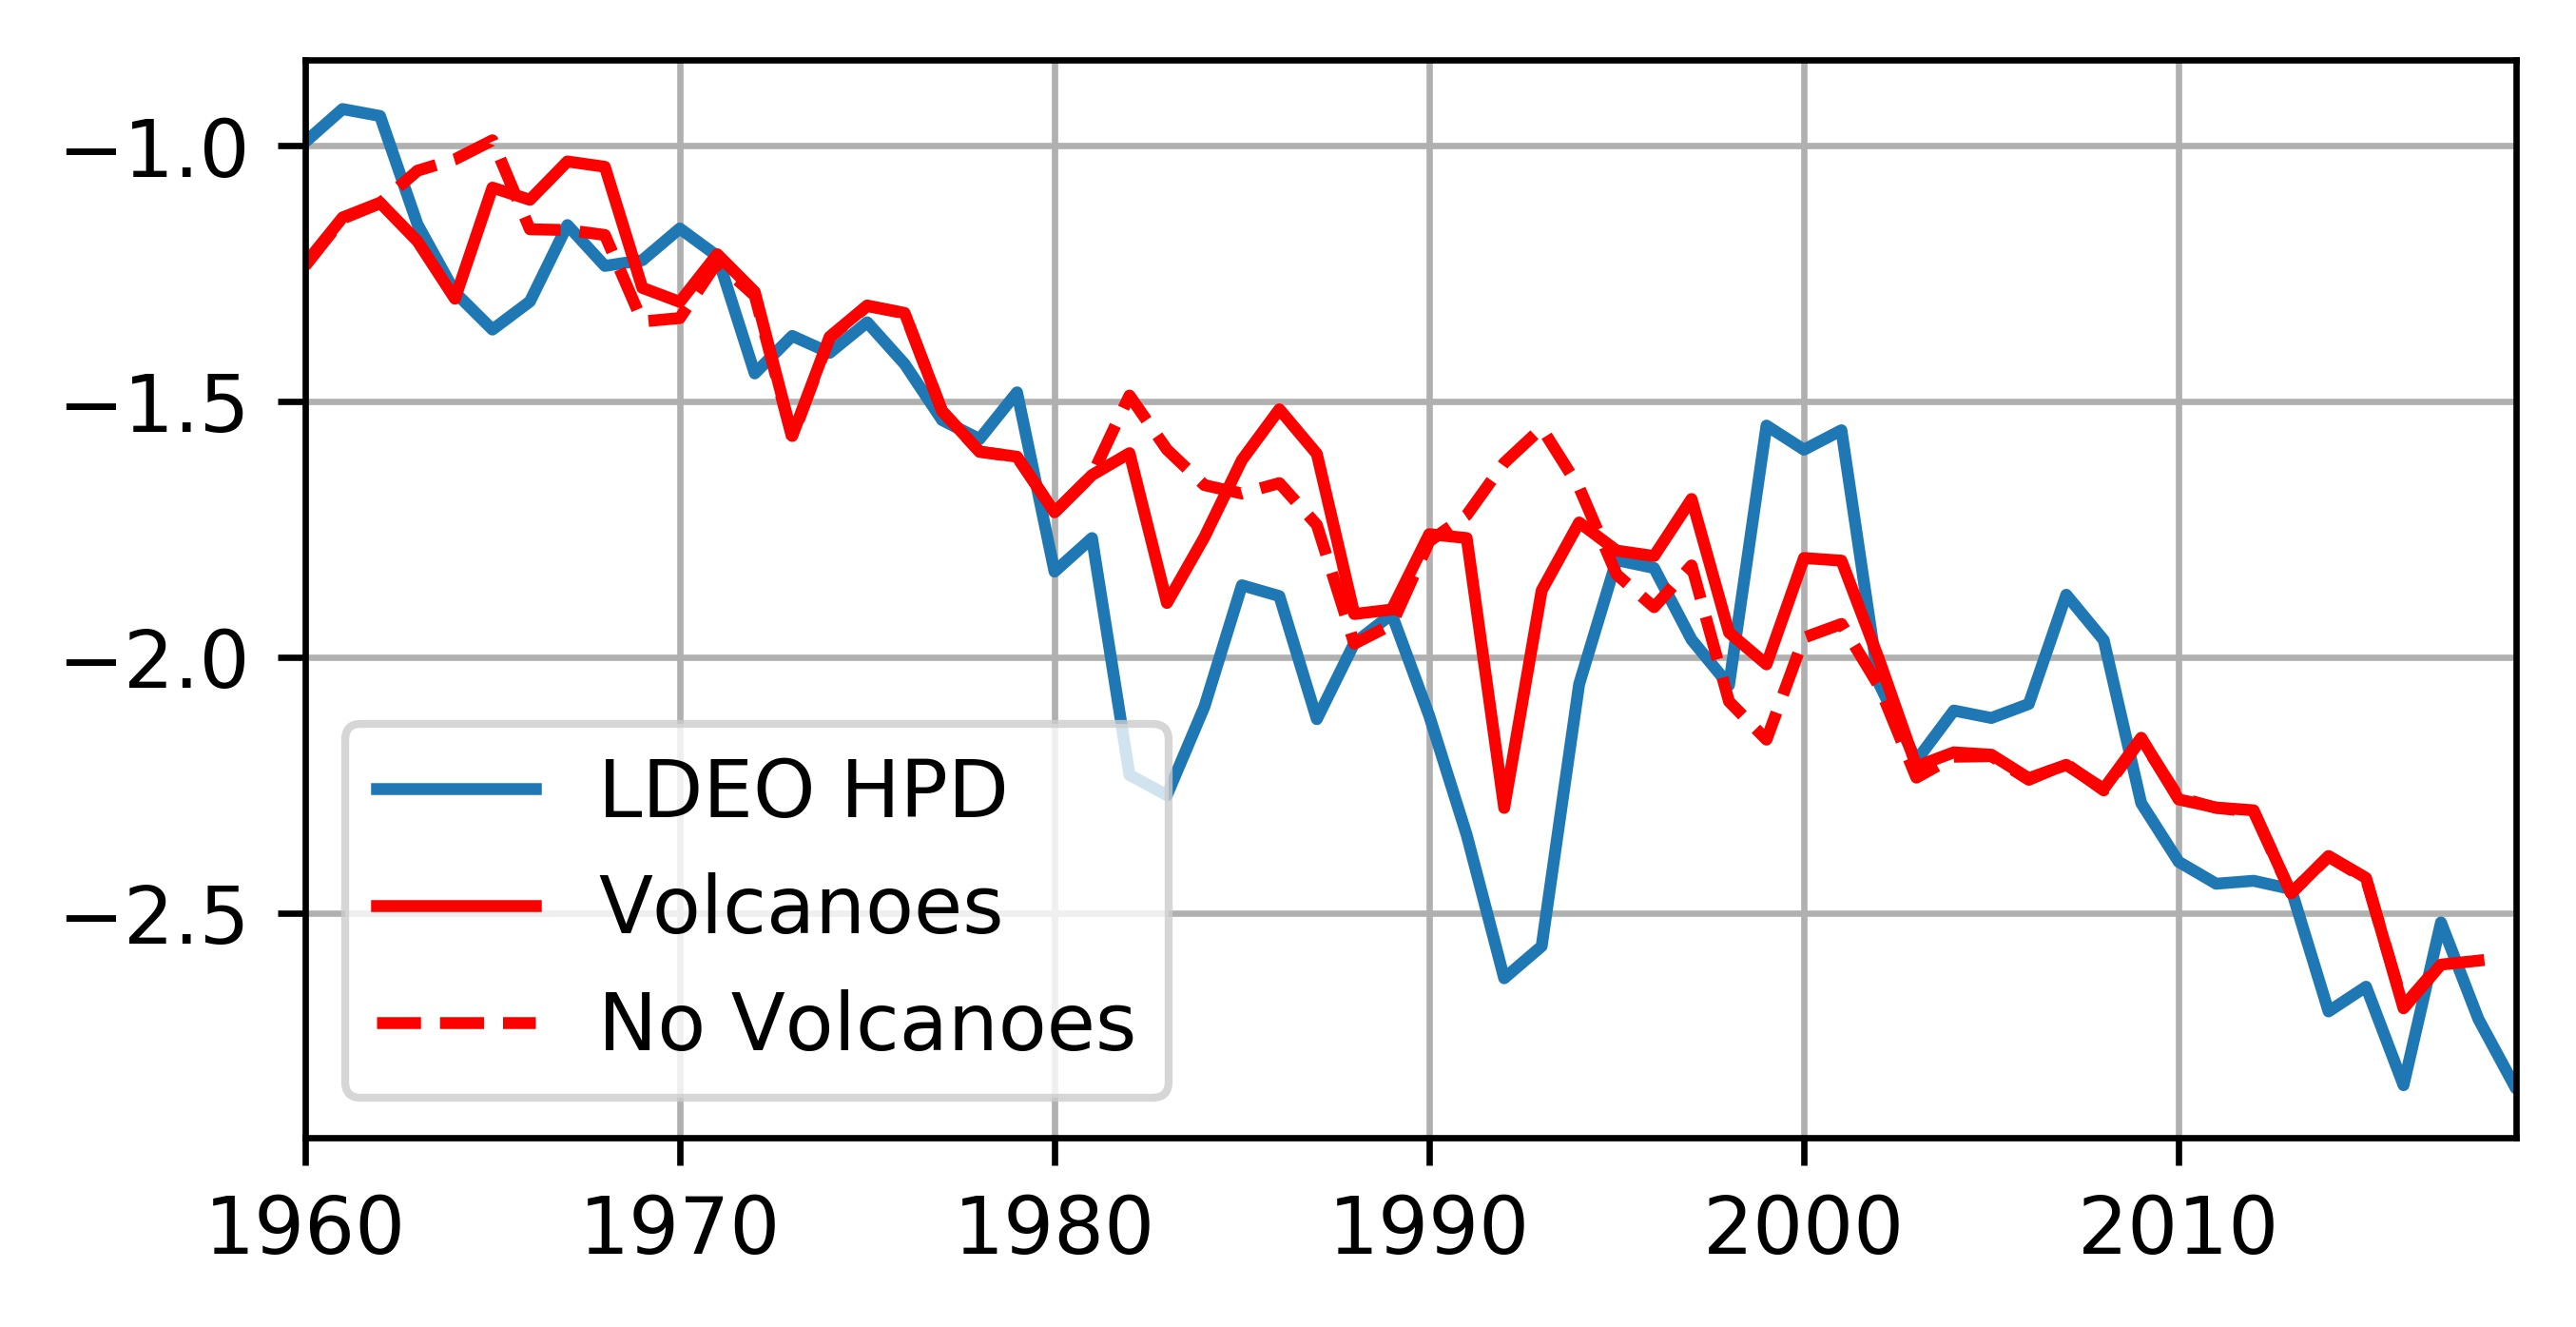

In [25]:
fig = plt.figure(figsize=(5,2.5))
plt.plot(hpd.year.sel(year=slice(1960,2020)),hpd.sel(year=slice(1960,2020))-0.49,label='LDEO HPD')
plt.plot(range(1960,2019),volcanos,color='red',label="Volcanoes")
plt.plot(range(1960,2018),no_volcanos,'r--',label="No Volcanoes")
plt.xlim(1960,2019)
plt.grid(True)
plt.legend()

## Four Panels 
#### (LDEO+LDEO-CLIM+GOBM, LDEO+JENA, LDEO+DATAPRODS, LDEO+BOXMODEL)

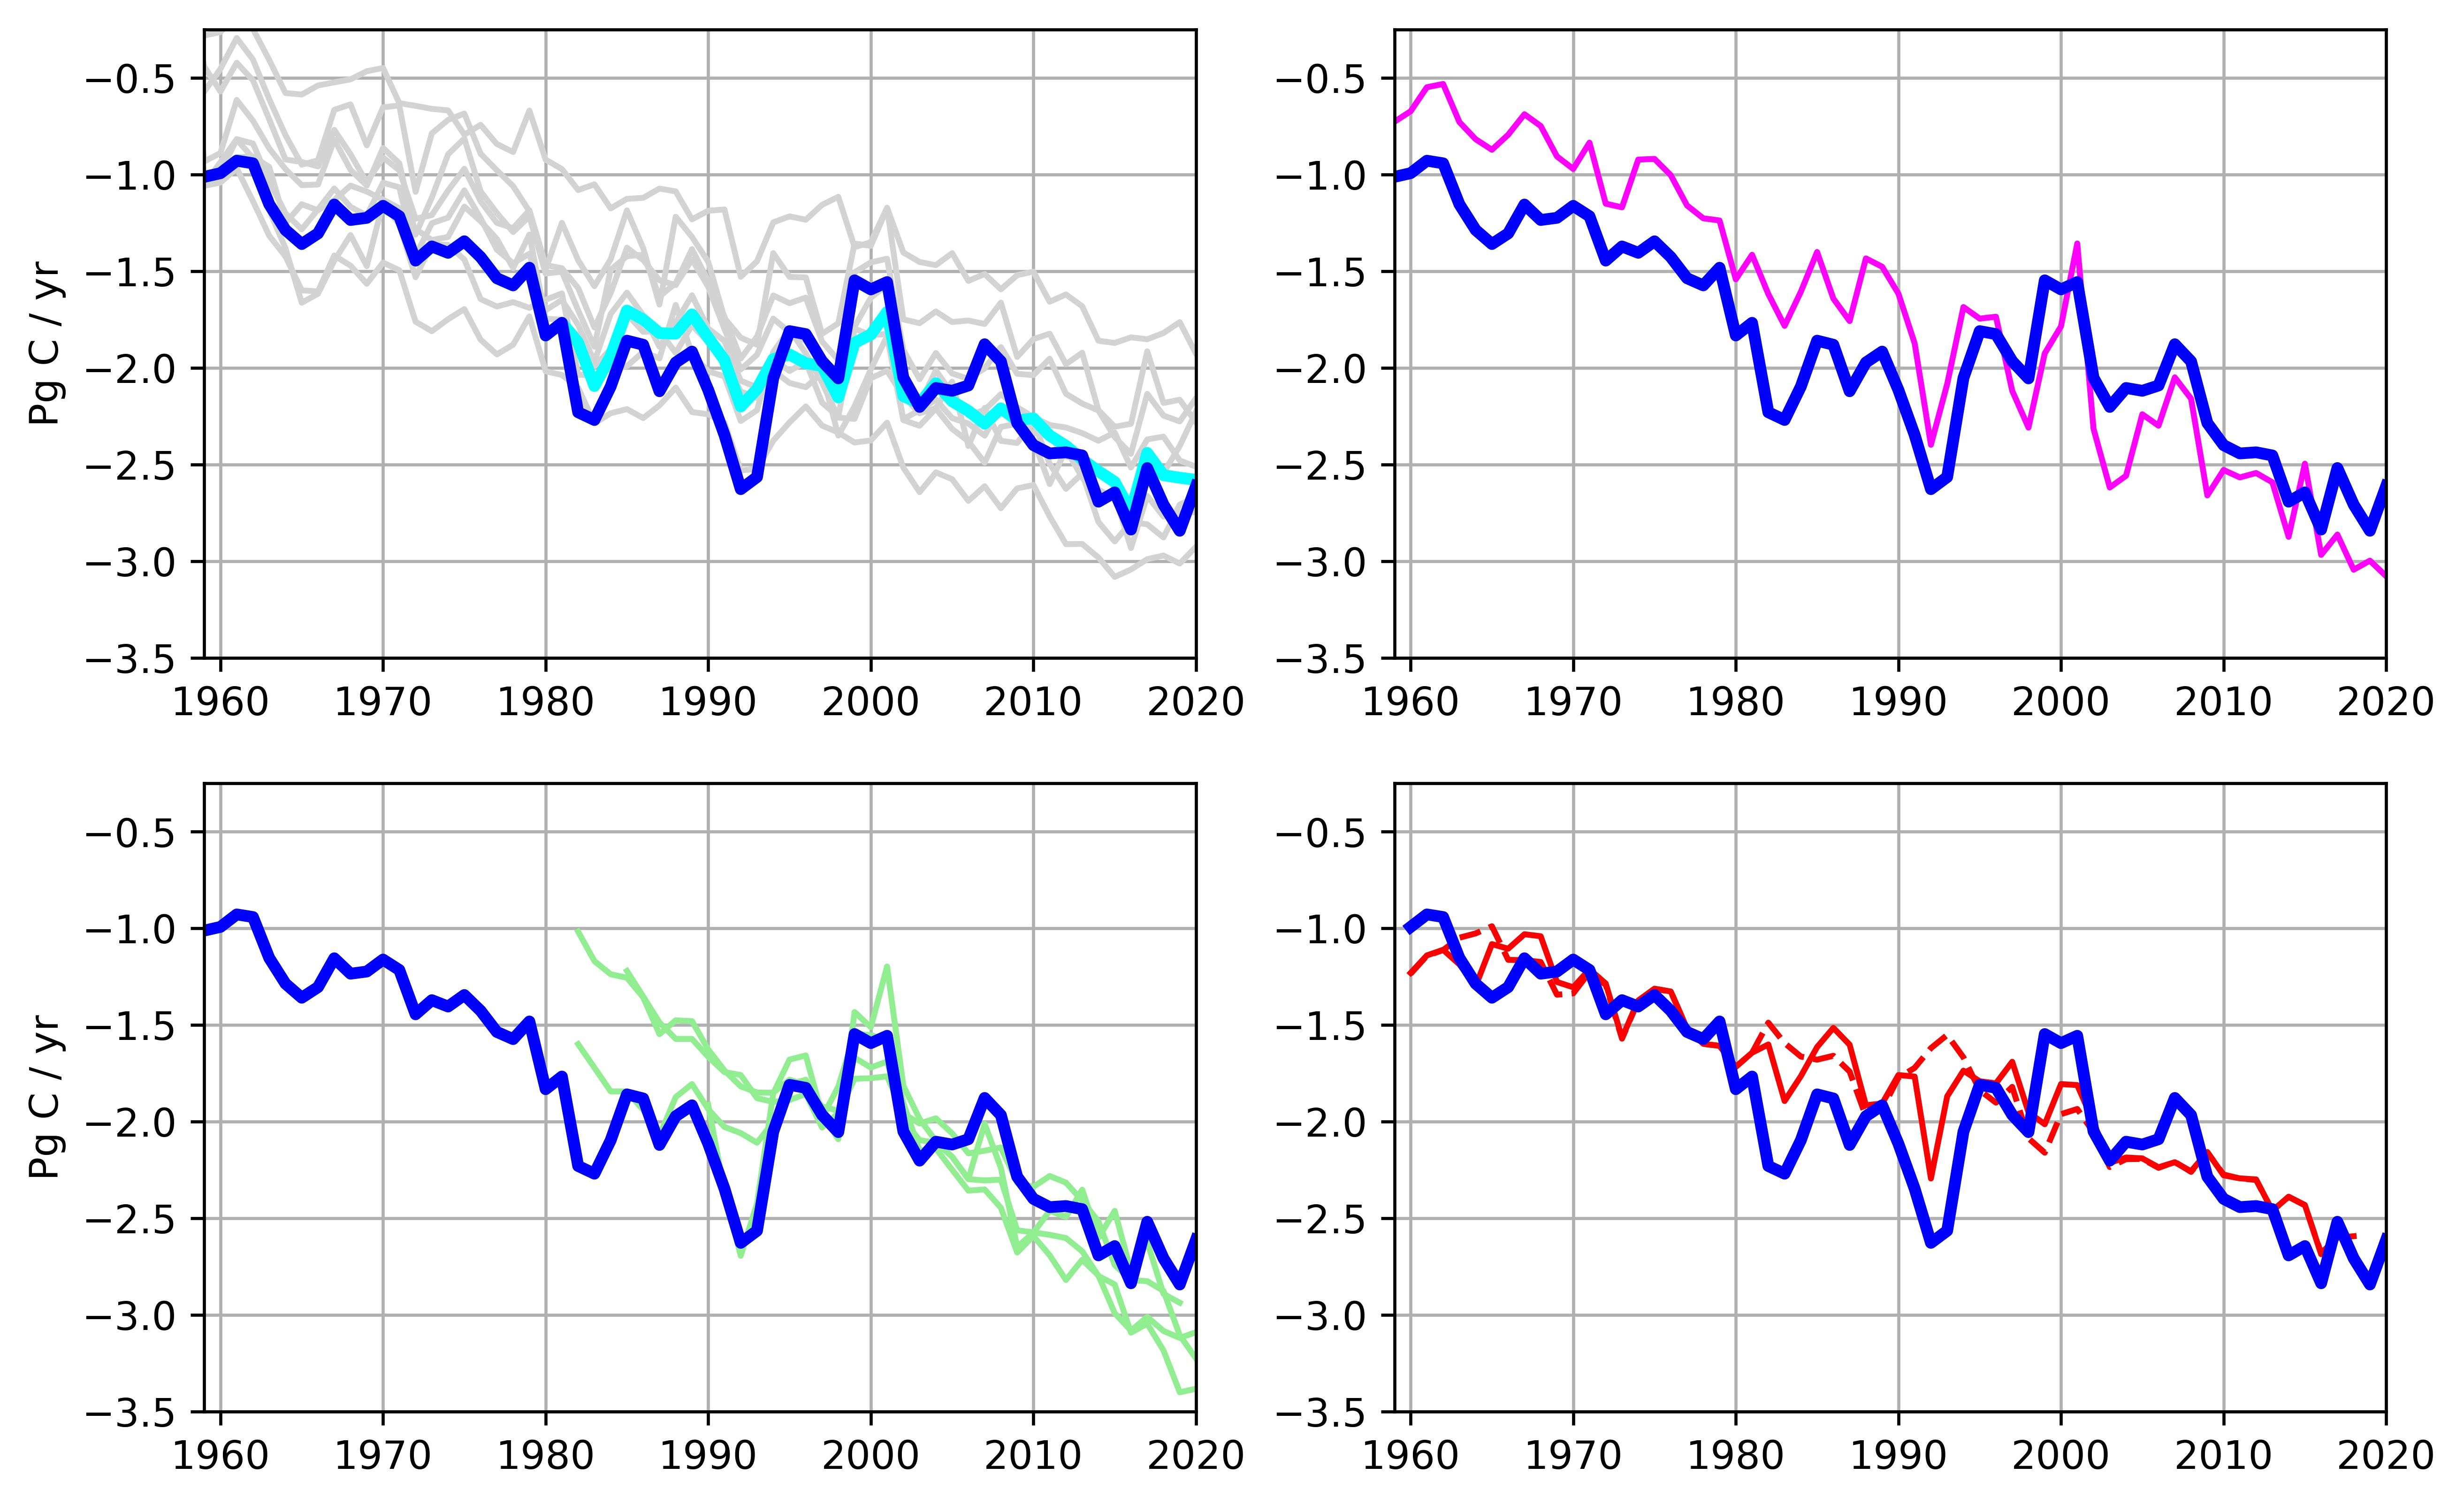

In [69]:
fig, axs = plt.subplots(2,2,figsize=(10,6.5))

# Top Left, LDEO-HPD, LDEO-HPD CLIM TEST, GOBMS:
for mod in models:
    var = dm[f"{mod}_annual_flux"]
    axs[0,0].plot(var.year,-1*var.values,color='lightgray') #label=f"{modname[m]}"
    del var
# Add HPD (Clim prior to 1982, HPD full from 1982 onward):
axs[0,0].plot(hpdclim.year.sel(year=slice(1959,2020)),hpdclim.sel(year=slice(1959,2020))-0.49,color='cyan',linewidth=3,label='LDEO HPD CC')
axs[0,0].plot(hpd.year.sel(year=slice(1959,2020)),hpd.sel(year=slice(1959,2020))-0.49,color='blue',linewidth=3,label='LDEO HPD')
axs[0,0].set_ylabel("Pg C / yr")
axs[0,0].set_ylim(-3.5,-0.25)
axs[0,0].grid(True)
axs[0,0].set_xlim(1959,2020)
#axs[0,0].set_title("LDEO-HPD and GOBMs")

# Top Right, LDEO-HPD and JENA MLS
axs[0,1].plot(carboscope.year,carboscope-0.49,color='magenta')#label=prod)
axs[0,1].plot(hpd.year.sel(year=slice(1959,2020)),hpd.sel(year=slice(1959,2020))-0.49,color='blue',linewidth=3,label='LDEO HPD')
axs[0,1].set_ylim(-3.5,-0.25)
axs[0,1].grid(True)
axs[0,1].set_xlim(1959,2020)
#axs[0,1].set_title("LDEO-HPD and Jena MLS")


# Bottom Left, LDEO-HPD and Data Products
#for prod in ["MPI_SOMFFN","CMEMS_FFNN","CSIR_ML6"]:
#    axs[1,0].plot(range(1990,2020),pflux[f"{prod}"]-0.49,color='lightgreen',linewidth=1.5)
# Add Other Products
for prod in ['land','cmems','csir']:
    axs[1,0].plot(range(1958,2021),-1*newprod[f"{prod}"]-0.49,color='lightgreen',linewidth=1.5)    
axs[1,0].plot(range(1990,2020),residual/10**15-0.49,color='lightgreen',linewidth=1.5)
axs[1,0].plot(hpd.year.sel(year=slice(1959,2020)),hpd.sel(year=slice(1959,2020))-0.49,color='blue',linewidth=3,label='LDEO HPD')
axs[1,0].set_ylim(-3.5,-0.25)
axs[1,0].set_ylabel("Pg C / yr")
axs[1,0].grid(True)
axs[1,0].set_xlim(1959,2020)
#axs[1,0].set_title("LDEO-HPD and Data Products")


# Bottom Right, LDEO-HPD and Box Model
axs[1,1].plot(range(1960,2019),volcanos,color='red',label="Volcanoes")
axs[1,1].plot(range(1960,2018),no_volcanos,'r--',label="No Volcanoes")
axs[1,1].plot(hpd.year.sel(year=slice(1960,2020)),hpd.sel(year=slice(1960,2020))-0.49,label='LDEO HPD',color='blue',linewidth=3)
axs[1,1].set_ylim(-3.5,-0.25)
axs[1,1].grid(True)
axs[1,1].set_xlim(1959,2020)
#axs[1,1].set_title("LDEO-HPD and Box Model")

#plt.legend()
#plt.title("Air-Sea CO$_2$ Flux")

plt.savefig(f"{recon_output_dir}/CO2flux_4panel_HPD_models_CarboScope_Products_BoxModel_1959-2020.eps",format='eps',dpi=600)

## Correlations

In [27]:
np.corrcoef(hpd.sel(year=slice(1960,2002)),volcanos[0:43])[0,1]  

0.8248075291266295

In [28]:
np.corrcoef(hpd.sel(year=slice(1960,2002)),no_volcanos[0:43])[0,1]  

0.6406647140693372

In [29]:
np.corrcoef(signal.detrend(hpd.sel(year=slice(1960,2002)).values),signal.detrend(volcanos[0:43]))[0,1]  
# Only go to 2002, because volcano/no volcano identical after that

0.5128953025885904

In [30]:
np.corrcoef(signal.detrend(hpd.sel(year=slice(1960,2002)).values),signal.detrend(no_volcanos[0:43]))[0,1]  
# Only go to 2002, because volcano/no volcano identical after that

-0.23360220805232496

In [31]:
pearson_coef, p_value = stats.pearsonr(signal.detrend(hpd.sel(year=slice(1960,2002)).values), signal.detrend(volcanos[0:43]))
print(pearson_coef)
print(p_value)

0.5128953025885904
0.00043687630868020634


In [32]:
np.corrcoef(signal.detrend(hpd.sel(year=slice(1960,2002)).values),signal.detrend(no_volcanos[0:43]))[0,1]
pearson_coef, p_value = stats.pearsonr(signal.detrend(hpd.sel(year=slice(1960,2002)).values), signal.detrend(no_volcanos[0:43]))
print(pearson_coef)
print(p_value)

-0.23360220805232498
0.13164665377944684


In [33]:
np.corrcoef(signal.detrend(hpd.sel(year=slice(1960,2017)).values),signal.detrend(fuego))[0,1]

0.43742096273746484